
### <span style="color:green;"> Deep Convolutional Generative Adversarial Network</span>
### <span style="color:purple;">What are GANs?</span>
```
Generative Adversarial Networks (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A generator ("the artist") learns to create images that look real, while a discriminator ("the art critic") learns to tell real images apart from fakes.
```

![High Level GAN Explained](assets/gan1.png)
> Image courtesy Tensorflow Tutorials

```
During training, the generator progressively becomes better at creating images that look real, while the discriminator becomes better at telling them apart. The process reaches equilibrium when the discriminator can no longer distinguish real images from fakes.
```

![High Level GAN Explained](assets/gan2.png)
> Image courtesy Tensorflow Tutorials

![](assets/dcgan.gif)
```
The images begin as random noise, and increasingly resemble hand written digits over time.
```

### Library Import

In [1]:
import torch
from torchvision import datasets,transforms as T
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

### Configurations

In [2]:
noise_shape=100
num_epochs = 50

### Dataloader

In [3]:
transform = T.Compose([T.ToTensor(),T.Normalize(mean=[0.5],std=[0.5])])

In [4]:
trainset = datasets.MNIST('trainset', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

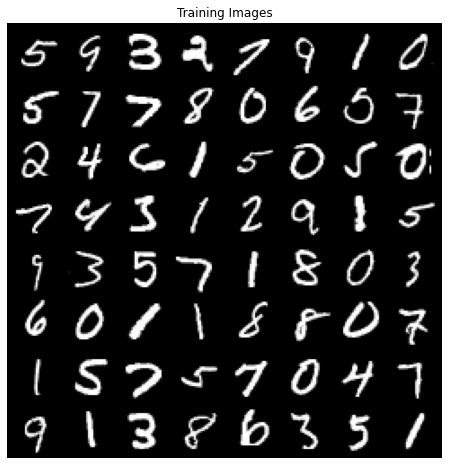

In [5]:
real_batch,_ = next(iter(trainloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to('cuda')[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### <span style="color:light green;">Generator Model Development</span>

![](assets/dcgan_generator.png)

<!-- 
![](assets/no_padding_no_strides_transposed.gif) ![](assets/no_padding_strides_transposed.gif)

![](assets/padding_strides_transposed.gif) ![](assets/same_padding_no_strides_transposed.gif) -->

In [7]:
def make_generator_model(noise_shape = 100,num_feat = 64):
    model = nn.Sequential(nn.ConvTranspose2d(noise_shape, num_feat * 8, kernel_size = 7, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(num_feat * 8),nn.LeakyReLU(), 
    nn.ConvTranspose2d(num_feat * 8, num_feat * 4, kernel_size = 5, stride = 2, padding=2,output_padding = 1, bias=False)
    ,nn.BatchNorm2d(num_feat * 4),nn.LeakyReLU(),
    nn.ConvTranspose2d(num_feat * 4, num_feat * 2, kernel_size = 5, stride = 2, padding=2,output_padding = 1, bias=False)
    ,nn.BatchNorm2d(num_feat * 2),nn.LeakyReLU(),
    nn.ConvTranspose2d( num_feat * 2,1, kernel_size = 5, stride = 1, padding=2, bias=False),
    nn.Tanh())
    return model

In [8]:
netG  =  make_generator_model()
netG  = netG.cuda()
# model(torch.randn((1,100,1,1))).shape

### Dicriminator Model Development

In [9]:
def make_discriminator_model(num_feat = 64):
    model = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=num_feat,kernel_size=5,stride=2,padding=2),
    nn.LeakyReLU(),nn.Dropout(p=0.3),
    nn.Conv2d(in_channels=num_feat,out_channels=num_feat*2,kernel_size=5,stride=2,padding=2),
    nn.LeakyReLU(),nn.Dropout(p=0.3),
    nn.Flatten(),nn.Linear(in_features=num_feat*2*7*7,out_features=1))
    return model

In [10]:
netD = make_discriminator_model()
netD  = netD.cuda()
# discriminator(torch.randn((1,1,28,28))).shape

In [11]:
# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device='cuda')

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training GAN

Some tips and tricks while trianing GAN - https://github.com/soumith/ganhacks

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data,_) in enumerate(trainloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to('cuda')
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device='cuda')
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, noise_shape, 1, 1, device='cuda')
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(trainloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1